In [22]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import IPython.display

In [23]:
def noising(data,noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def shifting(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def change_pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [24]:
data,sr = librosa.load('data/train/train_01000.wav')
mfcc_data = librosa.feature.melspectrogram(data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
mfcc_data.shape

(80, 138)

In [25]:
IPython.display.Audio(data=data, rate=sr)

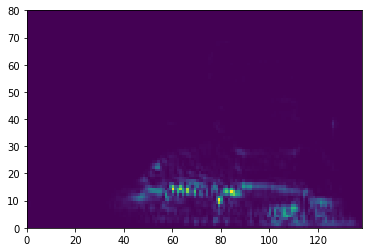

In [26]:
plt.pcolor(mfcc_data)
plt.show()

In [27]:
noising_data = noising(data,np.random.uniform(0,1))
mfcc_data = librosa.feature.melspectrogram(noising_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
mfcc_data.shape

(80, 138)

In [28]:
IPython.display.Audio(data=noising_data, rate=sr)

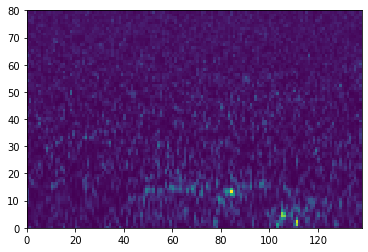

In [29]:
plt.pcolor(mfcc_data)
plt.show()

In [30]:
shifting_data = shifting(data,sr,0.3,'both')
mfcc_data = librosa.feature.melspectrogram(shifting_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
mfcc_data.shape

(80, 138)

In [31]:
IPython.display.Audio(data=shifting_data, rate=sr)

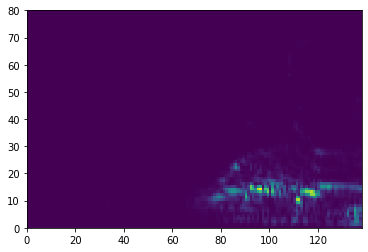

In [32]:
plt.pcolor(mfcc_data)
plt.show()

In [33]:
pitch_data = change_pitch(data,sr,np.random.randint(-5,5))
mfcc_data = librosa.feature.melspectrogram(pitch_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
mfcc_data.shape

(80, 138)

In [34]:
IPython.display.Audio(data=pitch_data, rate=sr)

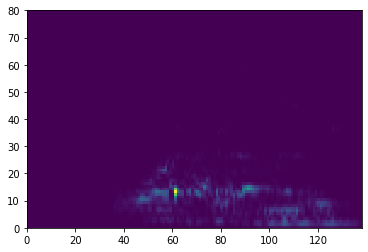

In [35]:
plt.pcolor(mfcc_data)
plt.show()

In [21]:
train_files = os.listdir('data/train')
try:
    os.mkdir('aug_data')
    os.mkdir('aug_data/train')
    os.mkdir('aug_data/test')
except:
    pass

for file in tqdm(train_files):
    data,sr = librosa.load('data/train/'+file)
    mfcc_data = torch.tensor(librosa.feature.melspectrogram(data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80))
    torch.save(mfcc_data,'aug_data/train/'+file.split('_')[1].split(".")[0]+'_0.pt')
    
    noise_data = noising(data,np.random.uniform(0,1))
    mfcc_data = torch.tensor(librosa.feature.melspectrogram(noise_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80))
    torch.save(mfcc_data,'aug_data/train/'+file.split('_')[1].split(".")[0]+'_1.pt')
    
    shift_data = shifting(data,sr,0.2,'both')
    mfcc_data = torch.tensor(librosa.feature.melspectrogram(shift_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80))
    torch.save(mfcc_data,'aug_data/train/'+file.split('_')[1].split(".")[0]+'_2.pt')
    
    pitch_data = change_pitch(data,sr,np.random.randint(-5,5))
    mfcc_data = torch.tensor(librosa.feature.melspectrogram(pitch_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80))
    torch.save(mfcc_data,'aug_data/train/'+file.split('_')[1].split(".")[0]+'_3.pt')

100%|██████████| 58840/58840 [39:09<00:00, 25.04it/s] 


In [35]:
train_files.index(file)

41160